# 12-07 16:35~

# 12-08 09:10~

# XGBoost(eXtra Gradient Boost)

## XGBoost 개요
- 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나
- 압도적인 수치의 차이는 아니지만, 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능을 나타냄
- GBM에 기반하지만, GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제 해결
- 특히 <span style="color:blue">병렬 CPU 환경에서 병렬 학습이 가능해</span> <span style="color:red">기존 GBM보다 빠르게 학습 완료</span>

#### XGBoost 장점
- 뛰어난 예측 성능
- GBM 대비 빠른 수행 시간
- 과적합 규제 
- 가지치기 (pruning) - 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 줄이게 됨
    - max_depth 파라미터로 가지치기 조정
- 교차 검증 내장
- 결손값 자체 처리


## XGBoost 라이브러리 -XGBoost 파이썬 구현

(1) XGBoost는 처음에는 C/C++로 작성되었음

(2) 파이썬에서도 XGBoost를 구동할 수 있도록 파이썬 패키지(xgboost) 제공
* 패키지 역할 : 대부분 C/C++ 핵심 라이브러리를 호출하는 것
* 사이킷런과 호환되지 않는 독자적인 XGBoost 전용 패키지
* 따라서 사이킷런의 fit(), predict() 메서드 같은 사이킷런 고유 아키텍처 적용 불가
* 다양한 유틸리티(cross_val_score, GridSearchCV, Pipeline 등)도 사용 불가
* '파이썬 래퍼 XGBoost 모듈'로 지칭

(3) 파이썬 기반의 ML 이용자들이 사이킷런을 많이 사용하기 때문에  
사이킷런과 연동할 수 있는 래퍼 클래스(Wrapper class) 제공
* XGBClassifer와 XGBRegressor 래퍼 클래스
*  사이킷런 estimator가 학습을 위해 사용하는 fit()과 predict() 등 
*  표준 사이킷런 개발 프로세스 및 다양한 유틸리티 활용 가능
* '사이킷런 래퍼 XGBoost 모듈'로 지칭

**'파이썬 래퍼 XGBoost 모듈'과 '사이킷런 래퍼 XGBoost 모듈' 차이점**
- '사이킷런 래퍼 XGBoost 모듈' : 사이킷런의 Estimator와 사용법 동일
- '파이썬 래퍼 XGBoost 모듈' : 파이썬 네이티브 XGBoost 고유의 API와 하이퍼 파라미터 이용
- 크게 다르지는 않지만 몇 가지 주의할 점이 있음
- 파이썬 Wrapper : 사이킷런 Wrapper
    - eta : learning_rate  (학습률)
    - num_boost_rounds : n_estimators  (학습기의 개수 : 반복 수행 횟수)    

XGBoost 설치
* Anaconda Prompt 관리자 모드로 열고 (mac - 터미널) 
* conda install -c anaconda py-xgboost

In [2]:
# XGBoost 버전 확인

import xgboost

print(xgboost.__version__) #안되면 Anaconda Prompt 관리자 모드로 열고 conda acitvate data_venv 하고나서 conda install -c anaconda py-xgboost

C:\anaconda3\envs\data_venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\anaconda3\envs\data_venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


1.5.0


## Boost Parameter
- eta: Learning rate(일반적으로 0.01 - 0.2)
- min_child_weight: chlid에서 필요한 모든 관측치에 대한 가중치의 최소 합
- max_depth: 트리 최대 깊이
- max_leaf_node: 최대 리프 수
- gamma: split 하기 위한 최소의 loss 감소 정의
- subsample: 데이터 중 샘플링(0.5 ~ 1)
- colsample_bytree: column 중 sampling(0.5 ~ 1)
- colsample_bylevel: 각 level마다 샘플링 비율
- lambda: L2 nrom (L2 regularization 가중치)
- alpha: L1 norm (L1 reguralization 가중치)
- scale_pos_weight: positive, negative weight 지정

# 위스콘신 유방암 예측 예제  
(1) 파이썬 Wrapper XGBoost 적용  
(2) 사이킷런 Wrapper XGBoost 적용

### (1) 파이썬 래퍼 XGBoost 적용 – 위스콘신 Breast Cancer 데이터 셋

- 악성 종양(malignant)인지 양성 종양(benign)인지를 분류한 세트
- 양성 : 제거하여 치유할 수 있는 종양. 성장속도 느리고 전이되지 않음
- 악성 : 암. 빠르게 성장하고 전이되어 생명 위협

xgboost : XGBoost의 파이썬 패키지
- 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능 포함
- 조기 중단 기능 : 수행 시간 개선 *****
    - 빠른 수행시간 처리 가능하지만
    - CPU 코어가 많지 않은 개인용 PC에서는 수행시간 향상 효과 보기 어려움

In [3]:
# 모듈 import
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore') #warning은 무시하도록 설정

In [4]:
# 데이터 세트 로딩
dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

In [5]:
# 데이터 확인하기 위해 데이터 프레임으로 생성
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label # 맨 마지막에 target 열 추가
cancer_df.head(3) #얘의 원본은 이미지

# target : 0 악성, 1 양성

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


위 데이터는 암 세포 데이터를 수치화해놓은 것이다.

In [6]:
# 레이블 값 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [7]:
# 학습 데이터/테스트 데이터 분리 8:2
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


### 파이썬 래퍼 XGBoost를 사용하려면
- 데이터를 DMatrix 타입으로 변환해서 사용해야 함
- DMatrix : XGBoost 전용 데이터 세트(XGBoost를 쓰려면 DMatrix 타입을 써야함. 그래서 DMAtrix로 변환시킬 수 있는 DMatrix()도 있다.)
- 변환 함수 : xgboost.DMatrix(data=피처데이터, label=target데이터)

검증데이터가 반드시 필요하고 우리는 검증데이터는 따로 나누지 않겠다고 설정했다. low가 1000개가 안 되기 때문에.
XGBoost 패키지 안에는 파이썬 자체에서만 쓸 수 있는 기능이 있고, XGBoost 패키지 안에 들어가있는 모듈 중에 하나는 사이킷런과 동일한 형태로 사용할 수 있는. 사이킷런과 호환이 되는 모듈도 들어가 있다. 그래서 파이썬래퍼, 사이킷런래퍼 이렇게 부르는데 우리는 일단 파이썬 전용 패키지인 XGBoost를 이용해서 모델링을 진행해봤다. 파이썬전용 패키지와 사이킷런에서 사용할 수 있는 모듈의 차이점은 파라미터다. 사이킷런에서 사용하는 파라미터 이름ㅇ르 그대로 차출해서 만들어놓은 게 사이킷런래퍼라고 불리는 거고, XGBoost를 만든. 원래 C언어로 만들어져있던 것을 파이썬으로 변환하면서 그 때는 C언어로 만들어진 XGBoost의 파라미터 이름ㅇ르 그대로 사용했다. 그래서 사이킷런에서 자주 사용하는 파라미터의 이름과 파이썬에서 사용하는 파라미터의 이름이 다르다. 어떻게 달라지는지만 기억하면 되고, 사용하는 방법이나 개념은 똑같이 XGBoost에 내장되어있는 것을 사용하게 된다.
 다만 파이썬의 XGBoost를 사용할때는 XGBoost 전용데이터인 DMatrix로 변환해서 사용해야 한다. 이건 파이썬의 기존 자료구조도 아니고, XGBoost가 나는 이렇게 쓰겠다고 만들어놓은 자료구조다. 그러니 당연히 만들 수 있는 함수도 넘겨줬다. 만들때 사용하는 함수가 DMatrix()다. 이걸 이용해서 변환을 시킬 때 피처와 타겟값을 당연히 넘겨줘야겠다. 그리고 피처이름도 같이 넘겨주면 모델이 학습을 할 때 피처1번, 피처2번 이런 식으로 학습을 정리하는 게 아니라 피처이름으로 학습의 결과를 정리하게 된다. 
  DMAtrix는 XGBoost가 자기가 사용하겠다고 결정을 해놓은 행렬에 해당한다. 일반적으로 Numpy 행렬과 다르게 되어있지만, 기본 개념은 행렬이라고 보면 되겠다. 

In [8]:
# 학습용/테스트용 모두 변환해야 함
dtrain = xgb.DMatrix(data=X_train, label=y_train,
                     feature_names = dataset.feature_names)
dtest = xgb.DMatrix(data=X_test, label=y_test,
                     feature_names = dataset.feature_names)

In [9]:
dtrain #DMatrix타입이라 나오는데 XGBoost 아니면 쓰지도 않는 타입임.

#### 하이퍼 파라미터 설정
- objective : 예측하는 결정 함수 설정 (0 또는 1 이진 분류이므로 binary:logistic)
    - objective : 최소값을 가져야할 손실함수를 정의
        - XGBoost는 다양한 손실함수를 사용하는데, 주로 이진분류인지 다중분류인지에 따라 달라짐

            - binary:logistic : 이진분류일 때 사용

            - multi:softmax : 다중 분류일 때 적용(0, 1, 2, 3, 4 이런 식이 아닌 각각에 대한 확률을 받고 싶다면 아래에서 나오는 multi:softprob를 사용한다.)
                - 손실함수가 multi:softmax일 경우 레이블 클래스의 개수인 num_class 파라미터를 지정해야 함

            - multi:softprob : multi:softmax와 유사하나 개별 레이블 클래스에 해당하는 예측 확률을 반환
            
- eval_metric : 오류 함수의 평가 성능 지표 
    - eval_metric : 검증에 사용되는 함수를 정의
    - 기본값은 회귀의 경우 mse, 분류일 경우 error
    - eval_metric 유형
        - mse : Mean Square Error(회귀)
        - mae : Mean Absolute Error(회귀)
        - logloss : Nagative log-likelihood(이진분류)
        - error : Binary classification error rate (0.5 threshold)(이진분류)
        - merror : Multiclass classification error rate(멀티분류)
        - mlogloss : Multiclass logloss(멀티분류)
        - auc : Area under the Curve(분류(이진/멀티)


In [10]:
# 파라미터 설정
params = {'max_depth': 3,
           'eta': 0.1 ,   #learning_rate #트리기 때문에 과적합은 제어하는 게 좋음 #숫자가 작을 수록 과적합이 일어날 수 있는데 그렇다고 숫자가 커도 과적합이 일어날 수 있다. 숫자가 크면 과소적합이 일어날 수 있다. 충분히 학습을 해야하는데 학습을 못하게 되는 거다. 숫자가 작으면 너무 그 자리에서만 도는 거다.(학습을 과하게 한다) 오차를 줄이는 방법으로 가중치를 주는데 가중치를 얼마나 늘려가면서 줄 것인가에 해당하는 내용이 learning_rate다. 이게 작을수록 가중치는 작아진다. 그렇게되면 충분한 학습이 일어나지 않을 수 있다. 횟수적으로는 충분히 학습을 한 횟수인데, learning_rate가 너무 작아서 학습의 결과가 무의미할 수 있다. 보통 0.1~0.2 정도의 값 안에서 사용을 한다. 여기서는 eta로 되어있고 사이킷런에서는 learning_rate라는 파라미터 명으로 되어있다. 결국 오차에 대해서 가중치를 줘서 작업을 하는 것이기 때문에 나온 결과값에 대해서 연속적인 수치로 값이 나타나게 된다. 그럼 나타나는 값이 0이냐 1이냐를 결정할 때 사용하는 함수가 ogjective다. 
          'objective':'binary:logistic', #'binary : logistic'는 우리가 지금 하려고 하는 게 이진분류이기 때문에 이진분류 logistic이라는 오브젝트를 사용한다는 뜻이다. 이진분류는 이걸 한다고 정해져있다고 함. 다중분류는 'binary : logistic' 대신 'multi:softmax'라고 쓰면 된다고 함.
           'eval_metric': 'logloss', # 코드 잘못 적음
           'silent' : 0,
           'vervosity':0
          }
#모델 갯수
num_rounds=400 #하나의 의사결정 트리르 만들어놓고 계속해서 (400번의)반복학습을 진행하게 된다.

**지정한 파라미터로 모델 학습**

In [11]:
## train 데이터 셋은 ‘train’ , evaluation 데이터 셋은 ‘eval'로 명기
wlist = [(dtrain,'train'),(dtest,'eval') ] # eval 평가용 #학습용을 평가할때는 dtrain을 쓰고 검증할때는 dtest를 쓰라는 말이다. 테스트 데이터를 넣으면 안 되고 검증용데이터를 따로 만들어서 넣어야 하는데 우리는 그냥 테스트 데이터를 쓰고 있다.

In [14]:
# 모델 학습
xgb_model = xgb.train(params=params,
                     dtrain=dtrain, #얘로 학습하고
                     num_boost_round = num_rounds,
                     early_stopping_rounds=100, #최대 반복횟수가 400번인데 성능평가지수가 더 이상 향상되지 않을때 기준으로 몇 번 더 수행할 것인지 지정 #여기를 주석처리 하고 실행했을때 200중후반번째에 가면 eval-logloss가 값이 오히려 오르고 있음. 이게 떨어지지 않고 올라갔다는 말은 과적합이 일어나고 있다는 것을 의미한다.
                     evals=wlist) #얘로 검증한다. 학습데이터와 검증데이터의 차이가 있어야 겠다.
#early_stopping_rounds는 반복했을때 어느 순간 성능평가지수(eval-logloss)가 향상되지 않으면 최소 100번은 더 반복하고 멈추라는 것이다. 

# 211이후 100번 더 반복 동안 성능 평가 지수가 향상되지 못해서 학습 종료 - 단 311까지 학습을 종료한 모델을 사용 
# 211이 best여도 311까지는 학습을 해야 성능을 높일 수 있음

[10:35:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent", "vervosity" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-loglo

### 테스트 데이터 세트에 예측 수행
- 파이썬 래퍼 XGBoost는 train() 함수를 호출해서 학습이 완료된 모델 객체 반환
- 이 모델 객체는 예측 수행할 때 predict() 메서드 사용
- predict()를 통해 예측 확률값 반환
- (사이킷런의 predict()는 예측 결과 클래스 값(0, 1) 반환
   - 예측 확률 반환 : predict_proba())

In [15]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))


predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]


In [16]:
# 예측 확률로 예측값이 반환 되므로 임계값을 정해 0또는 1로 변환해야 함
preds = [1 if x>0.5 else 0 for x in pred_probs]
print(np.round(preds[:10]))

[1 0 1 0 1 1 1 1 1 0]


### XGBoost 모델의 예측 성능 평가  
- get_clf_eval() 함수 적용

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [18]:
# 테스트 레이블 y_test 예측 레이블/예측확률 preds/pred_probs
get_clf_eval(y_test,preds,pred_probs) #굉장히 성능이 좋은 모델이기는 하다. 다만 맹점이 있는데 이렇게 써도 이 데이터에 대해서 이 정도의 성능 정도는 보장하는 모델이기는 한데 ~~~

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


### 위 모델은 검증용 데이터로 테스트 데이터를 사용했음.
- 학습되지 않은 데이터라도 익숙한 데이터일 수 있어서 위 성능은 오버되었을 가능성이 있다.

**xgboost 패키지에 내장된 시각화 기능 수행**
- plot_importance() API : 피처의 중요도를 막대그래프 형식으로 나타냄
    - 기본 평가 지료로 fi 스코어를 기반으로 해서 
    - 각 피처의 중요도 표시
   
   
**`plot_importance(학습이 완료된 모델 객체, Matplotlib의 ax)`**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

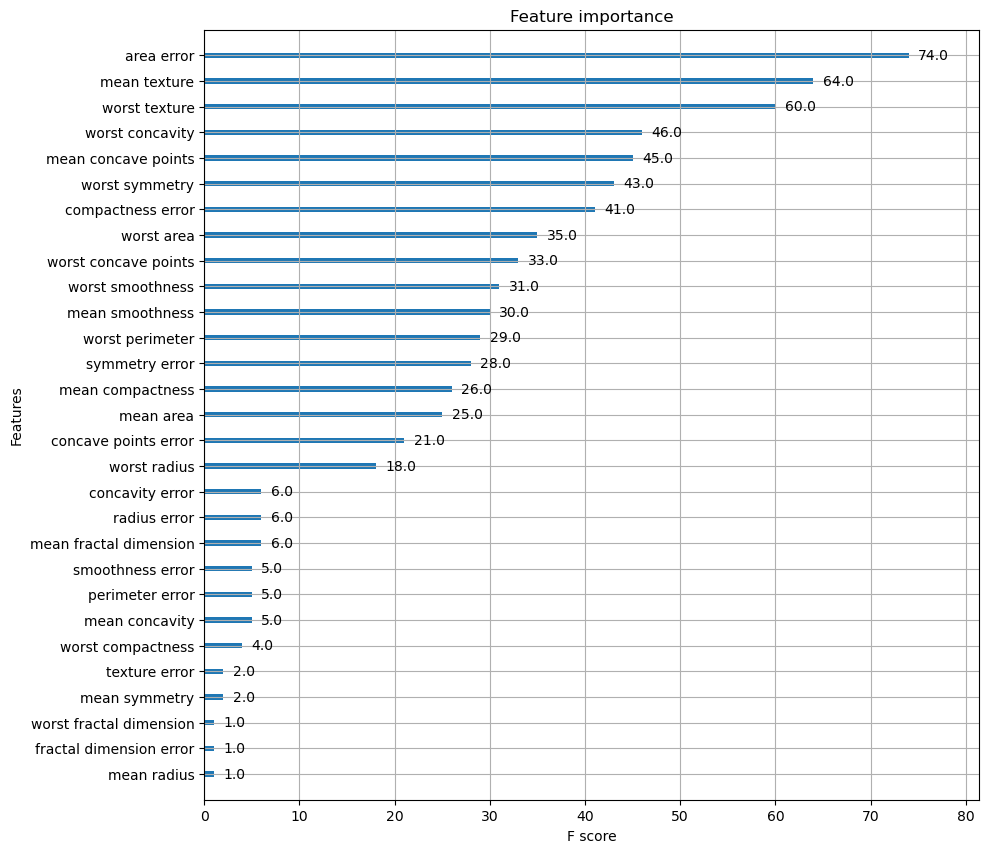

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10)) #1개의 그래프 공간 생성
plot_importance(xgb_model, ax=ax)

## (2) 사이킷런 Wrapper XGBoost 개요 및 적용

- 사이킷런의 기본 Estimator를 그대로 상속해서 만들었기 때문에  
- fit()과 predict()만으로 학습과 예측 가능  

- 하이퍼 파라미터 차이  
    - 파이썬 Wrapper : 사이킷런 Wrapper  
        - eta : learning_rate (학습률)  
        - num_boost_rounds : n_estimators (학습기의 개수 : 반복 수행 횟수)  

- 분류를 위한 XGBClassifier 클래스
- 회귀를 위한 XGBRegressor 클래스


- 파이썬 래퍼 XGBoost에서 사용하는 하이퍼파라미터와 호환성을 유지하기 위해 몇개 하이퍼파라미터를 변경
    - eta  → learning_rate
    - sub_sample → subsample
    - lambda → reg_lambda
    - alpha → reg_alpha
    
    
- xgboost의 n_estimators와 num_boost_round는 동일한 파라미터
    - 이를 동시에 사용할 경우 
        - 파이썬 래퍼 XGBoost API는 n_estimator를 무시하고 num_boost_round를 적용
        - 사이킷런 래퍼 XGBoost는 n_estimator 파라미터를 적용

In [20]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier #사이킷런에서 사용할 수 있는 XGBoost

In [21]:
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [22]:
# 주의사항 : 검증 데이터 세트를 따로 생성해서 검증을 진행 해야 함
# - 예제 데이터의 양이 검증요 데이터를 추출하기에 너무 적어 test용 데이터를 검증용과 테스트용으로 사용
# - 실제 분석에서는 이렇게 진행하면 안됨
X_feature_df = cancer_df.iloc[:,:-1]
y_label_df = cancer_df[['target']]
X_train, X_test, y_train, y_test = train_test_split(X_feature_df, y_label_df, test_size = 0.2, random_state=15)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [24]:
from xgboost import XGBClassifier
# 모델 객체 인스턴스 생성
evals = [(X_test, y_test)]

# 객체 인스턴스 생성시 파라미터 튜닝
xgb_wrapper = XGBClassifier(n_estimators=400,
                           learning_rate=0.1,
                           max_depth=3)

# 학습시킬때 전달해야하는 파라미터(학습 진행과 관련된)
xgb_wrapper.fit(X_train, y_train, eval_set = evals,
               eval_metric = 'logloss',
               early_stopping_rounds=400,
               verbose = True)

[0]	validation_0-logloss:0.61718
[1]	validation_0-logloss:0.55655
[2]	validation_0-logloss:0.50551
[3]	validation_0-logloss:0.46481
[4]	validation_0-logloss:0.42654
[5]	validation_0-logloss:0.39904
[6]	validation_0-logloss:0.37356
[7]	validation_0-logloss:0.35388
[8]	validation_0-logloss:0.33523
[9]	validation_0-logloss:0.32016
[10]	validation_0-logloss:0.30509
[11]	validation_0-logloss:0.28623
[12]	validation_0-logloss:0.27435
[13]	validation_0-logloss:0.25990
[14]	validation_0-logloss:0.24650
[15]	validation_0-logloss:0.23753
[16]	validation_0-logloss:0.22700
[17]	validation_0-logloss:0.22000
[18]	validation_0-logloss:0.21648
[19]	validation_0-logloss:0.20848
[20]	validation_0-logloss:0.20195
[21]	validation_0-logloss:0.19996
[22]	validation_0-logloss:0.19697
[23]	validation_0-logloss:0.19174
[24]	validation_0-logloss:0.18721
[25]	validation_0-logloss:0.18487
[26]	validation_0-logloss:0.18085
[27]	validation_0-logloss:0.17952
[28]	validation_0-logloss:0.17797
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
# 학습과 예측 수행 : fit(), predict(), predict_proba() 이용
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]


In [26]:
# 예측 성능 평가 수행
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  5]
 [ 1 74]]
정확도: 0.9474, 정밀도: 0.9367, 재현율: 0.9867,    F1: 0.9610, AUC:0.9815


In [27]:
# early stopping 설정
from xgboost import XGBClassifier

# 학습시킬때 전달해야하는 파라미터(학습 진행과 관련된)
xgb_wrapper.fit(X_train, y_train, eval_set = evals,
               eval_metric = 'logloss',
               early_stopping_rounds=10, #성능 변화가 없어서 10번을 더 진행했는데 성능에 변화가 없으면 멈추는 거고, 변화가 있으면 또다시 더 진행한다.
               verbose = True)           #만약 100번으로 잡았다면 100번을 더 진행하다가 성능에 변화가 있으면 더 진행하는 거다. early_stopping이 너무 짧게 잡혀있으면 파라미터를 튜닝했을때의 결과를 확인하기 위한 측면이 목적에 더 각밥다.

[0]	validation_0-logloss:0.61718
[1]	validation_0-logloss:0.55655
[2]	validation_0-logloss:0.50551
[3]	validation_0-logloss:0.46481
[4]	validation_0-logloss:0.42654
[5]	validation_0-logloss:0.39904
[6]	validation_0-logloss:0.37356
[7]	validation_0-logloss:0.35388
[8]	validation_0-logloss:0.33523
[9]	validation_0-logloss:0.32016
[10]	validation_0-logloss:0.30509
[11]	validation_0-logloss:0.28623
[12]	validation_0-logloss:0.27435
[13]	validation_0-logloss:0.25990
[14]	validation_0-logloss:0.24650
[15]	validation_0-logloss:0.23753
[16]	validation_0-logloss:0.22700
[17]	validation_0-logloss:0.22000
[18]	validation_0-logloss:0.21648
[19]	validation_0-logloss:0.20848
[20]	validation_0-logloss:0.20195
[21]	validation_0-logloss:0.19996
[22]	validation_0-logloss:0.19697
[23]	validation_0-logloss:0.19174
[24]	validation_0-logloss:0.18721
[25]	validation_0-logloss:0.18487
[26]	validation_0-logloss:0.18085
[27]	validation_0-logloss:0.17952
[28]	validation_0-logloss:0.17797
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
# 예측 성능 평가
# 학습과 예측 수행 : fit(), predict(), predict_proba() 이용
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
# 예측 성능 평가 수행
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  5]
 [ 1 74]]
정확도: 0.9474, 정밀도: 0.9367, 재현율: 0.9867,    F1: 0.9610, AUC:0.9815


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

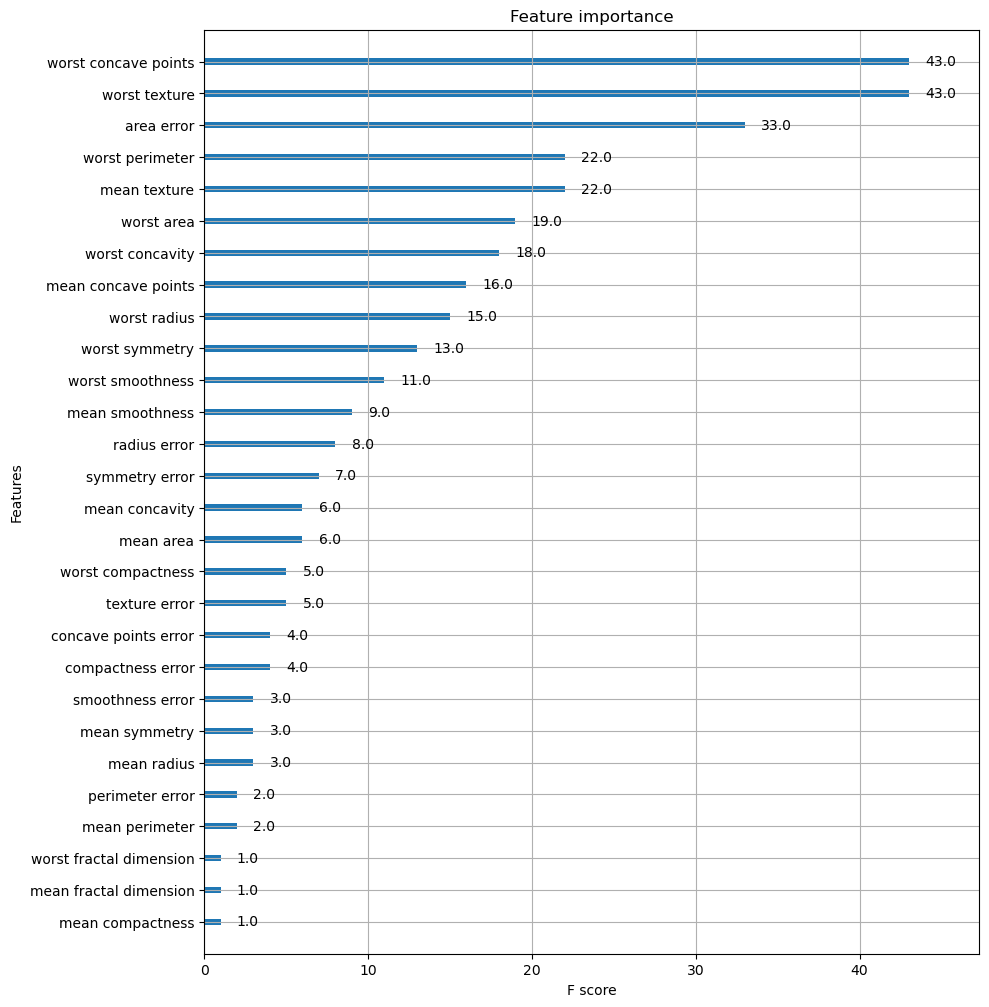

In [29]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)